In [1]:
# !nvidia-smi
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu==2.5.0

In [2]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
dir_path = "/content/data/data"


''' training path '''
train_p = os.path.join(dir_path, "train")

''' test path '''
test_p =os.path.join(dir_path, "test")

''' val path '''
val_p = os.path.join(dir_path, "val")


''' PNEUMONIA images '''
p_train_images = glob.glob(train_p + "/PNEUMONIA/*.jpeg")

''' NORMAL  images '''
n_train_images = glob.glob(train_p + "/NORMAL/*.jpeg")

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Data/data.zip" -d 'data'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


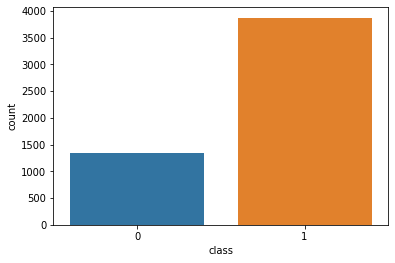

In [5]:
df = pd.DataFrame(np.concatenate([[0]*len(n_train_images) , [1] *  len(p_train_images)]),columns=["class"])
sns.countplot(df['class'],data=df)
plt.show()

In [6]:
''' Data Augmentation '''
train_ds = ImageDataGenerator(rescale =1/255, shear_range=10, zoom_range = 0.2, horizontal_flip = True, 
                              width_shift_range=0.2, fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1/255)

In [7]:
''' VGG16 Model '''

model1 = VGG16(include_top = False,weights='imagenet')

''' freezing layers '''
for i in model1.layers:
    i.trainable=False
    
out = model1.output

''' GlobalAveragePooling Layer '''
out = keras.layers.GlobalAveragePooling2D()(out)
out = keras.layers.Dense(128, activation='relu')(out)

''' Classification Layer '''
pred = keras.layers.Dense(1, activation='sigmoid')(out)

''' final model '''
model= keras.Model(model1.input, pred)

lr = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' Compile the model '''
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr_schedule), metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
''' lets see how model looks like '''
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [9]:
''' flow from directory '''
train_ds = train_ds.flow_from_directory(train_p, target_size=(150,150), batch_size= 16, class_mode='binary')

val_ds = val_datagen.flow_from_directory(val_p, target_size=(150,150),batch_size=8, class_mode='binary')

tes_ds = val_datagen.flow_from_directory(test_p, target_size=(150,150), batch_size=32, class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [10]:
''' training '''
history = model.fit(train_ds, steps_per_epoch = 100, epochs=20, validation_data=val_ds)

Epoch 1/20
100/100 [==============================] - 37s 244ms/step - loss: 2.0046 - accuracy: 0.7788 - val_loss: 0.5011 - val_accuracy: 0.6875
Epoch 2/20
100/100 [==============================] - 24s 243ms/step - loss: 0.4084 - accuracy: 0.8438 - val_loss: 0.2919 - val_accuracy: 0.9375
Epoch 3/20
100/100 [==============================] - 27s 269ms/step - loss: 0.3732 - accuracy: 0.8750 - val_loss: 0.2070 - val_accuracy: 0.9375
Epoch 4/20
100/100 [==============================] - 26s 261ms/step - loss: 0.3278 - accuracy: 0.8813 - val_loss: 0.3124 - val_accuracy: 0.8750
Epoch 5/20
100/100 [==============================] - 24s 237ms/step - loss: 0.3070 - accuracy: 0.9081 - val_loss: 1.1987 - val_accuracy: 0.6875
Epoch 6/20
100/100 [==============================] - 25s 248ms/step - loss: 0.3340 - accuracy: 0.8831 - val_loss: 0.2499 - val_accuracy: 0.8750
Epoch 7/20
100/100 [==============================] - 24s 236ms/step - loss: 0.2592 - accuracy: 0.9112 - val_loss: 0.3663 - val_ac

In [12]:
''' evaluating model '''
accuracy = model.evaluate_generator(tes_ds,624)[1]
accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


0.8958333134651184

In [13]:
''' unfreezing layers '''
for layer in model1.layers:
    layer.trainable = True

In [14]:
'''Finetuning the model'''
lr = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100000, decay_rate=0.96, staircase=True)

''' compile the model '''
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr_schedule), loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [16]:
''' training '''
model.fit(train_ds, steps_per_epoch = 50, epochs=100, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


50/50 [==============================] - 17s 252ms/step - loss: 0.3284 - binary_accuracy: 0.8788 - val_loss: 1.2573 - val_binary_accuracy: 0.6875
Epoch 2/100
50/50 [==============================] - 13s 259ms/step - loss: 0.2413 - binary_accuracy: 0.9162 - val_loss: 0.2229 - val_binary_accuracy: 0.9375
Epoch 3/100
50/50 [==============================] - 14s 280ms/step - loss: 0.2364 - binary_accuracy: 0.9013 - val_loss: 1.2695 - val_binary_accuracy: 0.7500
Epoch 4/100
50/50 [==============================] - 13s 253ms/step - loss: 0.2305 - binary_accuracy: 0.9075 - val_loss: 0.5240 - val_binary_accuracy: 0.8125
Epoch 5/100
50/50 [==============================] - 13s 252ms/step - loss: 0.1819 - binary_accuracy: 0.9350 - val_loss: 0.5816 - val_binary_accuracy: 0.8750
Epoch 6/100
50/50 [==============================] - 13s 257ms/step - loss: 0.1907 - binary_accuracy: 0.9312 - val_loss: 0.8706 - val_binary_accuracy: 0.7500
Epoch 7/100
50/50 [==============================] - 13s 256ms/s

In [19]:
''' evaluating model '''
final_acc = model.evaluate_generator(tes_ds,624)[1]
final_acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


0.932692289352417

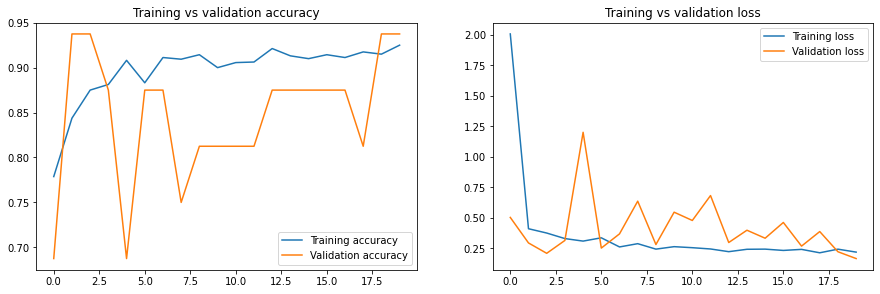

In [20]:
''' Training Accuracy and Validaion Accuracy graph '''
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label = "Training accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

''' Training Loss and Validation Loss graph '''
plt.subplot(2,2,2)
plt.plot(history.history['loss'], label = "Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [22]:
model.save('model_export.h5')